In [2]:
import os
import sys
import csv
from collections import Counter, OrderedDict
from enum import Enum
from typing import Dict, List, Tuple, Callable
import itertools
from termcolor import colored
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

sys.path.append('..')

from enums.ner_type import NERType

In [3]:
def printmd(string):
    display(Markdown(string))

In [4]:
language = 'french'

sys.argv = [
"--device cuda",
"--data-folder", "..\\data",
"--seed", "13",
"--configuration", "rnn-simple",
"--language", language,
"--challenge", "named-entity-recognition",
"--label-type", "coarse",
"--experiment-types", "word-similarity"]

In [5]:
# Configure container:
from dependency_injection.ioc_container import IocContainer

container = IocContainer()

In [6]:
file_service = container.file_service()
arguments_service = container.arguments_service()
metrics_service = container.metrics_service()
process_service = container.process_service()
plot_service = container.plot_service()


In [7]:
class ModelType(Enum):
    GroundTruth = 0
    Baseline = 1
    Ours = 2

class EntityMapping(Enum):
    LiteralFine = 'NE-FINE-LIT'
    LiteralCoarse = 'NE-COARSE-LIT'
    MetonymicFine = 'NE-FINE-METO'
    MetonymicCoarse = 'NE-COARSE-METO'
    Component = 'NE-FINE-COMP'
    Nested = 'NE-NESTED'

    @staticmethod
    def to_str(entity_mapping):
        if entity_mapping == EntityMapping.LiteralFine:
            return 'literal, fine'
        elif entity_mapping == EntityMapping.LiteralCoarse:
            return 'literal, coarse'
        elif entity_mapping == EntityMapping.MetonymicFine:
            return 'metonymic, fine'
        elif entity_mapping == EntityMapping.MetonymicCoarse:
            return 'metonymic, coarse'
        elif entity_mapping == EntityMapping.Component:
            return 'component'
        elif entity_mapping == EntityMapping.Nested:
            return 'nested'

        return ''

class TokenInfo:
    def __init__(
        self,
        token: str,
        literal_coarse_tag: str=None,
        literal_fine_tag: str=None,
        metonymic_coarse_tag: str=None,
        metonymic_fine_tag: str=None,
        content_tag: str=None,
        nested_tag: str=None):

        self.token = token
        
        self.data = {
            EntityMapping.LiteralFine: literal_fine_tag,
            EntityMapping.LiteralCoarse: literal_coarse_tag,
            EntityMapping.MetonymicFine: metonymic_coarse_tag,
            EntityMapping.MetonymicCoarse: metonymic_fine_tag,
            EntityMapping.Component: content_tag,
            EntityMapping.Nested: nested_tag,
        }

class NERDataStatistics:
    def __init__(self):
        self.content_tags = Counter()
        self.nested_entity_tags = Counter()
        self.literal_entity_tags: Dict[NERType, Counter] = {
            NERType.Coarse: Counter(),
            NERType.Fine: Counter(),
        }
        
        self.metonymic_entity_tags: Dict[NERType, Counter] = {
            NERType.Coarse: Counter(),
            NERType.Fine: Counter(),
        }

    def add_row_data(self, row):
        self.nested_entity_tags[row['NE-NESTED']] += 1
        self.content_tags[row['NE-FINE-COMP']] += 1

        self.literal_entity_tags[NERType.Coarse][row['NE-COARSE-LIT']] += 1
        self.literal_entity_tags[NERType.Fine][row['NE-FINE-LIT']] += 1

        self.metonymic_entity_tags[NERType.Coarse][row['NE-COARSE-METO']] += 1
        self.metonymic_entity_tags[NERType.Fine][row['NE-FINE-METO']] += 1

    def print_data(self):
        print('----------------')
        print('Statistics data:')
        print('----------------')
        self._print_collection_data(self.nested_entity_tags, 'unique nested entity tags')
        self._print_collection_data(self.content_tags, 'unique content tags')
        self._print_collection_data(self.literal_entity_tags[NERType.Fine], 'unique fine literal entity tags')
        self._print_collection_data(self.literal_entity_tags[NERType.Coarse], 'unique coarse literal entity tags')
        self._print_collection_data(self.metonymic_entity_tags[NERType.Fine], 'unique fine metonymic entity tags')
        self._print_collection_data(self.metonymic_entity_tags[NERType.Coarse], 'unique coarse metonymic entity tags')

    def _get_none_percentage(self, collection) -> float:
        result = (collection["O"] / sum(collection.values())) * 100
        return result
    
    def _print_collection_data(self, collection: Counter, name: str):
        print(f'{name}: {len(collection)} || None percentage: {self._get_none_percentage(collection)}')

def read_output_files(coarse_path, fine_path=None, print_stats=False):
    result = []
    statistics = NERDataStatistics()
    with open(coarse_path, 'r', encoding='utf-8') as coarse_file:
        reader = csv.DictReader(coarse_file, dialect=csv.excel_tab)
        for i, row in enumerate(reader):
            if row['TOKEN'].startswith('#'):
                continue
                
            statistics.add_row_data(row)
            token_info = TokenInfo(
                token=row['TOKEN'],
                literal_coarse_tag=row['NE-COARSE-LIT'].lower(),
                literal_fine_tag=row['NE-FINE-LIT'].lower())

            result.append(token_info)

    if fine_path is not None:
        with open(fine_path, 'r', encoding='utf-8') as fine_file:
            reader = csv.DictReader(fine_file, dialect=csv.excel_tab)
            counter = 0
            for i, row in enumerate(reader):
                if row['TOKEN'].startswith('#'):
                    continue
                
                statistics.add_row_data(row)

                result[counter].data[EntityMapping.LiteralFine] = row['NE-FINE-LIT'].lower()
                counter += 1
                
    if print_stats:
        statistics.print_data()
        
    return result

In [8]:
scorer_path = os.path.join('..', '..', '..', 'challenges', 'clef', 'scorer', 'CLEF-HIPE-2020-scorer')
version = "1.1"

dev_data_path = os.path.join(scorer_path, 'data', language, f'HIPE-data-v{version}-dev-{process_service.get_language_suffix(arguments_service.language)}.tsv')
train_data_path = os.path.join(scorer_path, 'data', language, f'HIPE-data-v{version}-train-{process_service.get_language_suffix(arguments_service.language)}.tsv')
baseline_coarse_path = os.path.join(scorer_path, 'output-french-coarse-baseline.tsv')
# baseline_fine_path = os.path.join(scorer_path, 'output-baseline-fine.tsv')
model_coarse_path = os.path.join(scorer_path, 'output-french-coarse-pretr.tsv')
# model_fine_path = os.path.join(scorer_path, 'output-french-fine-pretr.tsv')

# _ = read_output_files(train_data_path, dev_data_path, print_stats=True)

truth_tokens = read_output_files(dev_data_path)
baseline_tokens = read_output_files(baseline_coarse_path)#, baseline_fine_path)
new_tokens = read_output_files(model_coarse_path)
# new_tokens = read_output_files(model_coarse_path, model_fine_path)

assert len(baseline_tokens) == len(truth_tokens)
assert len(baseline_tokens) == len(new_tokens)

In [9]:
class ModelsDifference:
    def __init__(self):
        self.ground_truth = List[TokenInfo]
        self.tokens_by_model: Dict[ModelType, List[TokenInfo]] = {}
        self.difference_set: Dict[str, Counter] = {}

    def add_token_set(self, model_type: ModelType, tokens: List[TokenInfo]):
        if model_type == ModelType.GroundTruth:
            self.ground_truth = tokens
            return

        if model_type in self.tokens_by_model.keys():
            raise Exception("This model type is already added")

        self.tokens_by_model[model_type] = tokens

    def calculate_difference_set(self):
        self.difference_set = {}
        for i, truth_token_info in enumerate(self.ground_truth):
            self._calculate_difference_set_per_column(i, truth_token_info, EntityMapping.LiteralCoarse)
            self._calculate_difference_set_per_column(i, truth_token_info, EntityMapping.LiteralFine)
            self._calculate_difference_set_per_column(i, truth_token_info, EntityMapping.MetonymicCoarse)
            self._calculate_difference_set_per_column(i, truth_token_info, EntityMapping.MetonymicFine)
            self._calculate_difference_set_per_column(i, truth_token_info, EntityMapping.Component)
            self._calculate_difference_set_per_column(i, truth_token_info, EntityMapping.Nested)
            
    def _calculate_difference_set_per_column(self, i: int, truth_token_info: TokenInfo, entity_mapping: EntityMapping):
        predicted_values_by_model = { model_type: tokens[i].data[entity_mapping] for model_type, tokens in self.tokens_by_model.items() }
        difference_key = self._get_difference_key(truth_token_info.data[entity_mapping], predicted_values_by_model, entity_mapping)
        if difference_key not in self.difference_set.keys():
            self.difference_set[difference_key] = Counter()

        self.difference_set[difference_key][truth_token_info.token] += 1

    def _get_difference_key(
        self,
        truth_value: str,
        predicted_values_by_model: Dict[ModelType, str],
        entity_mapping: EntityMapping) -> str:
        results_dict = {}
        for model_type, predicted_value in predicted_values_by_model.items():
            results_dict[model_type] = (predicted_value == truth_value)

        result = self._get_difference_key_by_bool(results_dict, entity_mapping)
        return result
        
    def _get_difference_key_by_bool(
        self,
        desired_prediction_status: Dict[ModelType, bool],
        entity_mapping: EntityMapping) -> str:
        results_dict = OrderedDict(sorted(desired_prediction_status.items(), key=lambda x: x[0].value))
        result = '|'.join([f'{key.value}-{int(value)}' for key, value in results_dict.items()])
        result += f'|{entity_mapping.name}'

        return result

    def get_tokens_per_result(self, desired_prediction_status: Dict[ModelType, bool], entity_mapping: EntityMapping) -> Counter:
        key = self._get_difference_key_by_bool(desired_prediction_status, entity_mapping)
        if key not in self.difference_set.keys():
            return Counter()

        return self.difference_set[key]


In [10]:
models_difference = ModelsDifference()
models_difference.add_token_set(ModelType.GroundTruth, truth_tokens)
models_difference.add_token_set(ModelType.Baseline, baseline_tokens)
models_difference.add_token_set(ModelType.Ours, new_tokens)

models_difference.calculate_difference_set()

In [11]:
model_types = [ModelType.Baseline, ModelType.Ours]
entity_mappings = [EntityMapping.LiteralCoarse, EntityMapping.LiteralFine]

model_types_combinations = list(itertools.product([True, False], repeat=len(model_types)))
for entity_mapping in entity_mappings:
    for model_types_combination in model_types_combinations:
        desired_prediction_status_dict = { model_type : model_types_combination[i] for i, model_type in enumerate(model_types) }
        tokens_result = models_difference.get_tokens_per_result(
            desired_prediction_status_dict,
            entity_mapping)

        result_string = '### '
        result_string += f'{EntityMapping.to_str(entity_mapping)} -- '
        for model_type, value in desired_prediction_status_dict.items():
            result_string += 'correct' if value else 'wrong'
            result_string += f' by {model_type.name.lower()}, '

        result_string = result_string[:-2] + '\n'


        # for tag, values in tokens_result.items():
        # result_string += f'&nbsp;&nbsp;&nbsp;#### {tag}\n'

        result_string += f'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: {sum(tokens_result.values())}<br/>'
        most_common_string = '||'.join([f'\'{x[0]}\':{x[1]}' for x in tokens_result.most_common(10)])
        result_string += f'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||{most_common_string}||<br/>'
        
        printmd(result_string)

### literal, coarse -- correct by baseline, correct by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 27408<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||',':1416||'.':1365||''':1288||'de':1037||'la':618||'à':511||'l':456||'et':445||'le':413||'les':373||<br/>

### literal, coarse -- correct by baseline, wrong by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 816<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||'de':24||',':17||'Conseil':15||'-':13||'.':12||'du':12||'M':10||'fédéral':10||'York':10||'Suisse':9||<br/>

### literal, coarse -- wrong by baseline, correct by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 638<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||'.':56||',':29||'-':27||'de':25||''':22||'_':13||'"':13||'à':12||'M':9||'le':7||<br/>

### literal, coarse -- wrong by baseline, wrong by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 991<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||'de':54||',':39||'-':34||'.':31||''':22||'l':15||'M':11||'la':10||'des':8||'du':8||<br/>

### literal, fine -- correct by baseline, correct by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 0<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||||<br/>

### literal, fine -- correct by baseline, wrong by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 0<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||||<br/>

### literal, fine -- wrong by baseline, correct by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 0<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||||<br/>

### literal, fine -- wrong by baseline, wrong by ours
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Total amount**: 29853<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**- Top 10 most common**: ||',':1501||'.':1464||''':1341||'de':1140||'la':638||'à':533||'l':474||'et':456||'le':431||'d':376||<br/>

In [12]:
def plot_confusion_matrix(cm,
                          target_names=None,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

class IncorrectPrediction:
    def __init__(self, tag=None):
        self.tags = Counter()
        if tag is not None:
            self.tags[tag] += 1

    def __eq__(self, other):
        return sum(self.tags.values()) == sum(other.tags.values())
    
    def __lt__(self, other):
        return sum(self.tags.values()) < sum(other.tags.values())
    
    def __str__(self):
        return '<br/>'.join([f'{x[0]}:{x[1]}' for x in self.tags.most_common(3)])
        
    def __iadd__(self, other):
        new_counter = Counter()
        for tag, value in self.tags.items():
            new_counter[tag] += value
        
        for tag, value in other.tags.items():
            new_counter[tag] += value
        
        self.tags = new_counter
        return self
        
class ModelComparison:
    def __init__(self, comparison_title: str = None):
        
        self._comparison_title = comparison_title if comparison_title is not None else 'Confusion matrix'
        self._gt_data = { entity_mapping: [] for entity_mapping in EntityMapping }
        self._comparable_data = { entity_mapping: [] for entity_mapping in EntityMapping }
        self._tokens = []
        self._labels_mapping = { entity_mapping: {} for entity_mapping in EntityMapping }
        self._incorrect_predictions = { entity_mapping: {} for entity_mapping in EntityMapping }

    def add_tokens(self, gt_token_info, comparable_token_info):

        token = gt_token_info.token
        self._tokens.append(token)
        
        for entity_mapping in EntityMapping:
            gt_entity_tag = gt_token_info.data[entity_mapping]
            comparable_entity_tag = comparable_token_info.data[entity_mapping]
            
            if gt_entity_tag is None or comparable_entity_tag is None:
                continue
                
            self._gt_data[entity_mapping].append(gt_entity_tag)
            self._comparable_data[entity_mapping].append(comparable_entity_tag)
            
            if gt_entity_tag != comparable_entity_tag:
                if gt_entity_tag not in self._incorrect_predictions[entity_mapping].keys():
                    self._incorrect_predictions[entity_mapping][gt_entity_tag] = Counter()
                    
                if token not in self._incorrect_predictions[entity_mapping][gt_entity_tag].keys():
                    self._incorrect_predictions[entity_mapping][gt_entity_tag][token] = IncorrectPrediction(None)

                self._incorrect_predictions[entity_mapping][gt_entity_tag][token] += IncorrectPrediction(comparable_entity_tag)
            
    def get_incorrect_predictions_per_tag(self, entity_mapping: EntityMapping, limit: int = None):
        incorrect_predictions = self._incorrect_predictions[entity_mapping]
        if limit is not None:
            incorrect_predictions = {k: v.most_common(limit) for k, v in incorrect_predictions.items() }
            
        words_per_tag = OrderedDict({ k: [x for x in v] for k, v in sorted(incorrect_predictions.items(), key=lambda x: x[0][1:]) })
        return words_per_tag

    def plot_confusion_matrix(self, entity_mapping: EntityMapping):
        true_values = self._gt_data[entity_mapping]
        predicted_values = self._comparable_data[entity_mapping]
        if not true_values or not predicted_values:
            raise Exception(f'There are no values available for entity mapping \'{entity_mapping.name}\'')

        target_names = sorted(list(set(true_values + predicted_values)), key=lambda x: (x[1:], x))
        
        plot_service.plot_confusion_matrix(
            true_values,
            predicted_values,
            labels=target_names,
            normalize=True,
            title=f'{self._comparison_title}, {EntityMapping.to_str(entity_mapping)}')

def get_error_statistics(gt_tokens, comparable_tokens, comparison_title: str) -> ModelComparison:
    model_comparison = ModelComparison(comparison_title)

    for gt_token_info, comparable_token_info in zip(gt_tokens, comparable_tokens):
        model_comparison.add_tokens(gt_token_info, comparable_token_info)

    return model_comparison

model_comparison = get_error_statistics(truth_tokens, new_tokens, 'Our model(pre-trained) to ground truth')
baseline_comparison = get_error_statistics(truth_tokens, baseline_tokens, 'Baseline model to ground truth')

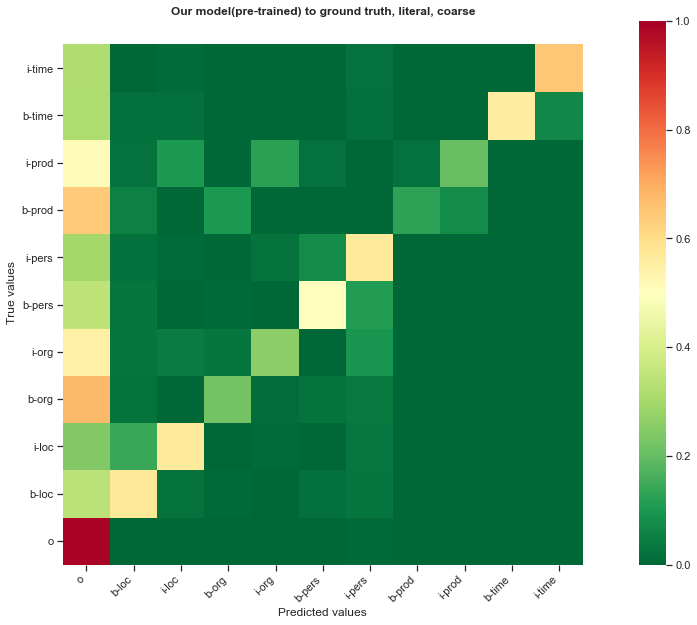

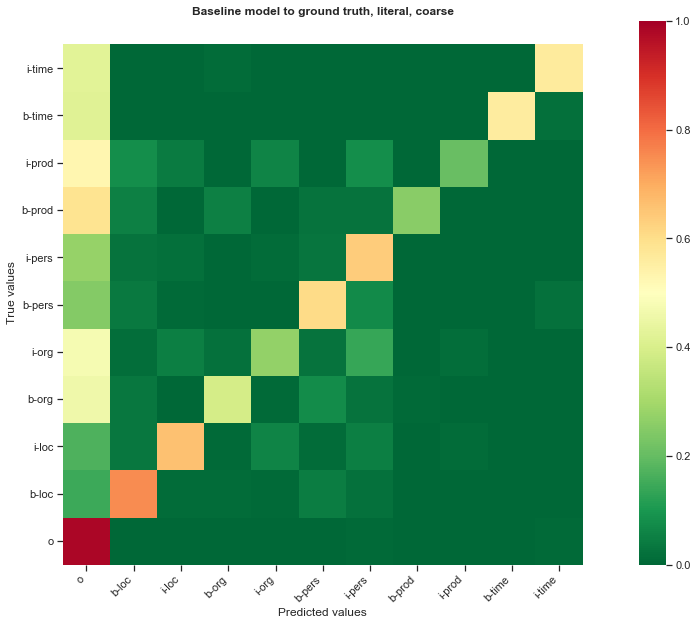

<Figure size 1440x720 with 0 Axes>

In [13]:
model_comparison.plot_confusion_matrix(EntityMapping.LiteralCoarse)
# model_comparison.plot_confusion_matrix(EntityMapping.LiteralFine)
baseline_comparison.plot_confusion_matrix(EntityMapping.LiteralCoarse)
# baseline_comparison.plot_confusion_matrix(EntityMapping.LiteralFine)

In [14]:
def print_incorrect_predictions_stats(entity_mapping: EntityMapping, limit: int = 10):
    incorrect_predictions = model_comparison.get_incorrect_predictions_per_tag(entity_mapping, limit)
    
    major_border_style = " style='border-top: 3px solid gray;'"
    border_style = " style='border: 1px solid gray;'"
    border_centered_style = " style='border: 1px solid gray; text-align: center;'"
    th_style = " style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'"
    
    result_string = f"<table style='border: 3px solid gray;'>"
    max_words = max([len(x) for x in incorrect_predictions.values()])
    
    result_string += f"""
        <tr {major_border_style}>
            <th colspan='{max_words+2}' style='border: 1px solid gray; text-align: center;'>
                Top {limit} incorrect predictions for {EntityMapping.to_str(entity_mapping)}
            </th>
        </tr>
        <tr>
            <td style='border: 1px solid gray; text-align: center;'>Entity</td>
            <td colspan='{max_words}' style='border: 1px solid gray; text-align: center;'>Top 10 most mistaken words and their top 3 tags which were predicted for them</td>
            <td style='border: 1px solid gray; text-align: center;'>Total incorrect<br/>predictions for<br/>this tag</td>
        </tr>"""
    
    for entity_tag, words in incorrect_predictions.items():
        while len(words) < max_words:
            words.append(('', IncorrectPrediction()))

        words_string = f"</td><td {border_centered_style}>".join([f'<b>{str(x[0])}</b>' for x in words])
        counts_string = f"</td><td {border_style}>".join([f'<i>{str(x[1])}</i>' for x in words])
        total_count = sum([sum(x[1].tags.values()) for x in words])
        result_string += f"""
            <tr {major_border_style}>
                <th rowspan='2' {th_style}>{entity_tag}</th>
                <td {border_centered_style}>{words_string}</td>
                <td rowspan='2' {border_centered_style}><b>{total_count}</b></td>
            </tr>
            <tr {border_style}>
                <td {border_style}>{counts_string}</td>
            </tr>"""
        
    result_string += '</table><br/>'
    
    printmd(result_string)

In [15]:
print_incorrect_predictions_stats(EntityMapping.LiteralCoarse)
# print_incorrect_predictions_stats(EntityMapping.LiteralFine, limit=5)

<table style='border: 3px solid gray;'>
        <tr  style='border-top: 3px solid gray;'>
            <th colspan='12' style='border: 1px solid gray; text-align: center;'>
                Top 10 incorrect predictions for literal, coarse
            </th>
        </tr>
        <tr>
            <td style='border: 1px solid gray; text-align: center;'>Entity</td>
            <td colspan='10' style='border: 1px solid gray; text-align: center;'>Top 10 most mistaken words and their top 3 tags which were predicted for them</td>
            <td style='border: 1px solid gray; text-align: center;'>Total incorrect<br/>predictions for<br/>this tag</td>
        </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>o</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>de</b></td><td  style='border: 1px solid gray; text-align: center;'><b>,</b></td><td  style='border: 1px solid gray; text-align: center;'><b>.</b></td><td  style='border: 1px solid gray; text-align: center;'><b>-</b></td><td  style='border: 1px solid gray; text-align: center;'><b>du</b></td><td  style='border: 1px solid gray; text-align: center;'><b>des</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Union</b></td><td  style='border: 1px solid gray; text-align: center;'><b>'</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Conseil</b></td><td  style='border: 1px solid gray; text-align: center;'><b>(</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>83</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>i-pers:8<br/>i-org:6<br/>i-loc:5</i></td><td  style='border: 1px solid gray;'><i>i-pers:10</i></td><td  style='border: 1px solid gray;'><i>i-pers:7<br/>i-time:1<br/>b-loc:1</i></td><td  style='border: 1px solid gray;'><i>i-loc:6<br/>i-pers:2</i></td><td  style='border: 1px solid gray;'><i>i-loc:3<br/>i-pers:2<br/>b-time:1</i></td><td  style='border: 1px solid gray;'><i>i-org:4<br/>i-loc:2<br/>i-pers:1</i></td><td  style='border: 1px solid gray;'><i>i-org:5<br/>i-pers:1<br/>b-org:1</i></td><td  style='border: 1px solid gray;'><i>i-org:3<br/>i-pers:2<br/>i-time:1</i></td><td  style='border: 1px solid gray;'><i>b-org:5</i></td><td  style='border: 1px solid gray;'><i>i-pers:4<br/>b-org:1</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>b-loc</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>Suisse</b></td><td  style='border: 1px solid gray; text-align: center;'><b>France</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Esp</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Londres</b></td><td  style='border: 1px solid gray; text-align: center;'><b>New</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Etats</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Bohême</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Confédération</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Turquie</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Fr</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>57</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:10</i></td><td  style='border: 1px solid gray;'><i>o:8<br/>i-pers:1</i></td><td  style='border: 1px solid gray;'><i>o:8<br/>i-loc:1</i></td><td  style='border: 1px solid gray;'><i>o:6<br/>i-time:1</i></td><td  style='border: 1px solid gray;'><i>o:5</i></td><td  style='border: 1px solid gray;'><i>o:2<br/>i-loc:2</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td><td  style='border: 1px solid gray;'><i>o:3</i></td><td  style='border: 1px solid gray;'><i>o:3</i></td><td  style='border: 1px solid gray;'><i>o:1<br/>i-pers:1<br/>b-pers:1</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>i-loc</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>de</b></td><td  style='border: 1px solid gray; text-align: center;'><b>York</b></td><td  style='border: 1px solid gray; text-align: center;'><b>-</b></td><td  style='border: 1px solid gray; text-align: center;'><b>la</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Majorque</b></td><td  style='border: 1px solid gray; text-align: center;'><b>française</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Berne</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Saint</b></td><td  style='border: 1px solid gray; text-align: center;'><b>d</b></td><td  style='border: 1px solid gray; text-align: center;'><b>'</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>42</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:11</i></td><td  style='border: 1px solid gray;'><i>b-loc:7<br/>o:2</i></td><td  style='border: 1px solid gray;'><i>o:4<br/>i-pers:1</i></td><td  style='border: 1px solid gray;'><i>o:3</i></td><td  style='border: 1px solid gray;'><i>o:3</i></td><td  style='border: 1px solid gray;'><i>o:2<br/>i-org:1</i></td><td  style='border: 1px solid gray;'><i>b-loc:2</i></td><td  style='border: 1px solid gray;'><i>b-loc:2</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>i-pers:1<br/>o:1</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>b-org</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>Conseil</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Havas</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Continental</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Banque</b></td><td  style='border: 1px solid gray; text-align: center;'><b>AGIP</b></td><td  style='border: 1px solid gray; text-align: center;'><b>H</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Société</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Action</b></td><td  style='border: 1px solid gray; text-align: center;'><b>FDIC</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Chambres</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>52</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:15<br/>i-pers:1</i></td><td  style='border: 1px solid gray;'><i>o:6<br/>b-loc:2</i></td><td  style='border: 1px solid gray;'><i>o:5</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td><td  style='border: 1px solid gray;'><i>o:3<br/>i-org:1</i></td><td  style='border: 1px solid gray;'><i>o:3</i></td><td  style='border: 1px solid gray;'><i>o:2<br/>i-pers:1</i></td><td  style='border: 1px solid gray;'><i>o:3</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>i-org</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>de</b></td><td  style='border: 1px solid gray; text-align: center;'><b>.</b></td><td  style='border: 1px solid gray; text-align: center;'><b>-</b></td><td  style='border: 1px solid gray; text-align: center;'><b>'</b></td><td  style='border: 1px solid gray; text-align: center;'><b>national</b></td><td  style='border: 1px solid gray; text-align: center;'><b>fédéral</b></td><td  style='border: 1px solid gray; text-align: center;'><b>l</b></td><td  style='border: 1px solid gray; text-align: center;'><b>des</b></td><td  style='border: 1px solid gray; text-align: center;'><b>nationale</b></td><td  style='border: 1px solid gray; text-align: center;'><b>et</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>84</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:12<br/>i-loc:2<br/>i-pers:1</i></td><td  style='border: 1px solid gray;'><i>i-pers:8<br/>o:5</i></td><td  style='border: 1px solid gray;'><i>i-loc:5<br/>o:4<br/>i-pers:2</i></td><td  style='border: 1px solid gray;'><i>o:9</i></td><td  style='border: 1px solid gray;'><i>o:7<br/>b-org:1</i></td><td  style='border: 1px solid gray;'><i>o:7</i></td><td  style='border: 1px solid gray;'><i>o:6</i></td><td  style='border: 1px solid gray;'><i>o:6</i></td><td  style='border: 1px solid gray;'><i>o:5</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>i-pers</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>,</b></td><td  style='border: 1px solid gray; text-align: center;'><b>.</b></td><td  style='border: 1px solid gray; text-align: center;'><b>de</b></td><td  style='border: 1px solid gray; text-align: center;'><b>-</b></td><td  style='border: 1px solid gray; text-align: center;'><b>'</b></td><td  style='border: 1px solid gray; text-align: center;'><b>du</b></td><td  style='border: 1px solid gray; text-align: center;'><b>M</b></td><td  style='border: 1px solid gray; text-align: center;'><b>à</b></td><td  style='border: 1px solid gray; text-align: center;'><b>l</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Santos</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>151</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:46</i></td><td  style='border: 1px solid gray;'><i>o:18<br/>i-org:2</i></td><td  style='border: 1px solid gray;'><i>o:14<br/>i-org:5</i></td><td  style='border: 1px solid gray;'><i>o:9<br/>i-loc:7<br/>i-org:1</i></td><td  style='border: 1px solid gray;'><i>o:11<br/>i-org:1</i></td><td  style='border: 1px solid gray;'><i>o:8<br/>i-org:1</i></td><td  style='border: 1px solid gray;'><i>b-pers:7<br/>o:1</i></td><td  style='border: 1px solid gray;'><i>o:7</i></td><td  style='border: 1px solid gray;'><i>o:7</i></td><td  style='border: 1px solid gray;'><i>b-pers:5<br/>o:1</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>b-pers</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>M</b></td><td  style='border: 1px solid gray; text-align: center;'><b>général</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Olano</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Chirac</b></td><td  style='border: 1px solid gray; text-align: center;'><b>président</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Zulle</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Nelfon</b></td><td  style='border: 1px solid gray; text-align: center;'><b>de</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Planta</b></td><td  style='border: 1px solid gray; text-align: center;'><b>prés</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>56</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:6<br/>i-pers:2<br/>i-loc:1</i></td><td  style='border: 1px solid gray;'><i>o:6<br/>i-pers:2</i></td><td  style='border: 1px solid gray;'><i>o:6<br/>i-pers:1</i></td><td  style='border: 1px solid gray;'><i>i-pers:3<br/>o:3</i></td><td  style='border: 1px solid gray;'><i>o:3<br/>i-pers:2</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td><td  style='border: 1px solid gray;'><i>i-pers:2<br/>i-loc:1<br/>i-org:1</i></td><td  style='border: 1px solid gray;'><i>o:4</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>b-prod</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>Petit</b></td><td  style='border: 1px solid gray; text-align: center;'><b>TSR</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Illico</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Dernières</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Echo</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Radio</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Presse</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Bund</b></td><td  style='border: 1px solid gray; text-align: center;'><b>L</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Feuille</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>20</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:3</i></td><td  style='border: 1px solid gray;'><i>o:1<br/>b-loc:1<br/>b-org:1</i></td><td  style='border: 1px solid gray;'><i>o:2<br/>b-org:1</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>i-prod:2</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>b-org:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>i-prod</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>de</b></td><td  style='border: 1px solid gray; text-align: center;'><b>-</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Parisien</b></td><td  style='border: 1px solid gray; text-align: center;'><b>York</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Nouvelles</b></td><td  style='border: 1px solid gray; text-align: center;'><b>zig</b></td><td  style='border: 1px solid gray; text-align: center;'><b>to</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Sport</b></td><td  style='border: 1px solid gray; text-align: center;'><b>d</b></td><td  style='border: 1px solid gray; text-align: center;'><b>'</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>19</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:3<br/>i-org:2</i></td><td  style='border: 1px solid gray;'><i>i-loc:2<br/>i-org:1<br/>o:1</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>i-loc:2</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>i-org:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>b-time</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>de</b></td><td  style='border: 1px solid gray; text-align: center;'><b>le</b></td><td  style='border: 1px solid gray; text-align: center;'><b>du</b></td><td  style='border: 1px solid gray; text-align: center;'><b>En</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Le</b></td><td  style='border: 1px solid gray; text-align: center;'><b>à</b></td><td  style='border: 1px solid gray; text-align: center;'><b>Avant</b></td><td  style='border: 1px solid gray; text-align: center;'><b>1914</b></td><td  style='border: 1px solid gray; text-align: center;'><b>pour</b></td><td  style='border: 1px solid gray; text-align: center;'><b>début</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>17</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:4<br/>i-loc:1</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>b-loc:1<br/>i-time:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>i-time:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td>
            </tr>
            <tr  style='border-top: 3px solid gray;'>
                <th rowspan='2'  style='border: 1px solid gray; background: rgba(150,150,150,0.3); text-align: right;'>i-time</th>
                <td  style='border: 1px solid gray; text-align: center;'><b>1914</b></td><td  style='border: 1px solid gray; text-align: center;'><b>septembre</b></td><td  style='border: 1px solid gray; text-align: center;'><b>l</b></td><td  style='border: 1px solid gray; text-align: center;'><b>-</b></td><td  style='border: 1px solid gray; text-align: center;'><b>1907</b></td><td  style='border: 1px solid gray; text-align: center;'><b>ler</b></td><td  style='border: 1px solid gray; text-align: center;'><b>août</b></td><td  style='border: 1px solid gray; text-align: center;'><b>14</b></td><td  style='border: 1px solid gray; text-align: center;'><b>avril</b></td><td  style='border: 1px solid gray; text-align: center;'><b>1915</b></td>
                <td rowspan='2'  style='border: 1px solid gray; text-align: center;'><b>14</b></td>
            </tr>
            <tr  style='border: 1px solid gray;'>
                <td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>o:2</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td><td  style='border: 1px solid gray;'><i>o:1</i></td>
            </tr></table><br/>

In [31]:
last_coarse = ''
counter = 0
counts = []
total_b_count = 0
tag_counter = Counter()
for i, token_info in enumerate(truth_tokens):
    tag_counter[token_info.data[EntityMapping.LiteralCoarse]] += 1
#     # print(f'{token_info.token}-{token_info.data[EntityMapping.LiteralCoarse]}-{truth_tokens[i+2625].data[EntityMapping.LiteralCoarse]}')
#     if len(last_coarse) > 1 and len(token_info.data[EntityMapping.LiteralCoarse]) > 1 and last_coarse[0] == 'b' and token_info.data[EntityMapping.LiteralCoarse][0] == 'b' and last_coarse[1:] != token_info.data[EntityMapping.LiteralCoarse][1:]:
#     # if last_coarse == token_info.data[EntityMapping.LiteralCoarse]:#:
#         total_b_count += 1
#     # else:
#         # if counter == 0 and last_coarse[0] == 'i':
#         # if counter > 0 and last_coarse[0] == 'b':
#             # total_b_count += 1

#         # counter = 0

#     last_coarse = token_info.data[EntityMapping.LiteralCoarse]

# print(total_b_count)
# all_tags = sum(tag_counter.values())
# print({k:((float(v))/all_tags)*100 for k,v in tag_counter.items()})

{'o': 89.68612869728335, 'b-loc': 1.808863430810974, 'b-pers': 1.8356614075637288, 'i-pers': 3.8287609285498942, 'b-org': 0.5192107995846313, 'i-org': 0.8474860148058821, 'i-loc': 0.6732991659129736, 'b-time': 0.19093558436338057, 'i-time': 0.3148762268448732, 'b-prod': 0.13064013666968144, 'i-prod': 0.1641376076106254}
